In [1]:
"""
Avellaneda & Lee (2010)-style statistical arbitrage on S&P 100
Using sector ETF factors and Yahoo Finance data.

- Universe: S&P 100 stocks (user fills in tickers + sector ETF map)
- Factors: Sector ETFs (e.g., XLK, XLF, XLE, etc.)
- Data: 2022-01-01 to 2025-12-31 from Yahoo Finance
- Backtest: 2025 only
- Method:
    1. For each stock & date, regress past 60 days of returns on sector ETF returns
    2. Compute residuals, rolling mean & std → s-scores
    3. Generate mean-reversion signals based on s-scores
    4. Build daily dollar-neutral portfolio across stocks
    5. Compute performance metrics and plot equity curve
"""

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:

# -------------------------------
# 1. CONFIGURATION
# -------------------------------

# IMPORTANT: Fill this with your S&P 100 tickers (no spaces, Yahoo symbols)
# You can start with a subset while debugging, then expand.
SP100_TICKERS = [
    "AAPL","ABBV","ABT","ACN","ADBE","AIG","AMD","AMGN","AMT","AMZN",
    "AVGO","AXP","BA","BAC","BK","BKNG","BLK","BMY","C",
    "CAT","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX",
    "DE","DHR","DIS","DUK","EMR","FDX","GD","GE","GILD","GM",
    "GOOG","GOOGL","GS","HD","HON","IBM","INTC","INTU","ISRG","JNJ",
    "JPM","KO","LIN","LLY","LMT","LOW","MA","MCD","MDLZ","MDT",
    "MET","META","MMM","MO","MRK","MS","MSFT","NEE","NFLX","NKE",
    "NOW","NVDA","ORCL","PEP","PFE","PG","PLTR","PM","PYPL","QCOM",
    "RTX","SBUX","SCHW","SO","SPG","T","TGT","TMO","TMUS","TSLA",
    "TXN","UBER","UNH","UNP","UPS","USB","V","VZ","WFC","WMT","XOM"
]


# Sector ETFs (SPDR Select Sector funds, for example)
SECTOR_ETFS = [
    "XLE",  # Energy
    "XLF",  # Financials
    "XLK",  # Technology
    "XLV",  # Health Care
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLI",  # Industrials
    "XLB",  # Materials
    "XLU",  # Utilities
    "XLC",  # Communication Services (post-2018)
    "XLRE", # Real Estate
]

MARKET_ETF = "SPY"  # For optional beta-neutrality vs market

# Map each stock to ONE sector ETF (simplest version of A&L ETF-factor model)
# !!! You MUST fill this mapping properly for your tickers !!!
# Example mapping for a few names:
SECTOR_ETF_MAP = {
    # Information Technology → XLK
    "AAPL": "XLK",
    "ACN":  "XLK",
    "ADBE": "XLK",
    "AMD":  "XLK",
    "AVGO": "XLK",
    "CRM":  "XLK",
    "CSCO": "XLK",
    "IBM":  "XLK",
    "INTC": "XLK",
    "INTU": "XLK",
    "MSFT": "XLK",
    "NOW":  "XLK",
    "NVDA": "XLK",
    "ORCL": "XLK",
    "PLTR": "XLK",
    "QCOM": "XLK",
    "TXN":  "XLK",

    # Health Care → XLV
    "ABBV": "XLV",
    "ABT":  "XLV",
    "AMGN": "XLV",
    "CVS":  "XLV",
    "DHR":  "XLV",
    "GILD": "XLV",
    "ISRG": "XLV",
    "JNJ":  "XLV",
    "LLY":  "XLV",
    "MDT":  "XLV",
    "MRK":  "XLV",
    "PFE":  "XLV",
    "TMO":  "XLV",
    "UNH":  "XLV",

    # Financials → XLF
    "AIG":  "XLF",
    "AXP":  "XLF",
    "BAC":  "XLF",
    "BK":   "XLF",
    "BLK":  "XLF",
    "C":    "XLF",
    "COF":  "XLF",
    "GS":   "XLF",
    "JPM":  "XLF",
    "MA":   "XLF",
    "MET":  "XLF",
    "MS":   "XLF",
    "PYPL": "XLF",
    "SCHW": "XLF",
    "USB":  "XLF",
    "V":    "XLF",
    "WFC":  "XLF",

    # Real Estate → XLRE
    "AMT": "XLRE",
    "SPG": "XLRE",

    # Consumer Discretionary → XLY
    "AMZN": "XLY",
    "BKNG": "XLY",
    "GM":   "XLY",
    "HD":   "XLY",
    "LOW":  "XLY",
    "MCD":  "XLY",
    "NKE":  "XLY",
    "SBUX": "XLY",
    "TGT":  "XLY",
    "TSLA": "XLY",

    # Consumer Staples → XLP
    "CL":   "XLP",
    "COST": "XLP",
    "KO":   "XLP",
    "MDLZ": "XLP",
    "MO":   "XLP",
    "PEP":  "XLP",
    "PG":   "XLP",
    "PM":   "XLP",
    "WMT":  "XLP",

    # Communication Services → XLC
    "CMCSA": "XLC",
    "DIS":   "XLC",
    "GOOG":  "XLC",
    "GOOGL": "XLC",
    "META":  "XLC",
    "NFLX":  "XLC",
    "T":     "XLC",
    "TMUS":  "XLC",
    "VZ":    "XLC",

    # Energy → XLE
    "COP":  "XLE",
    "CVX":  "XLE",
    "XOM":  "XLE",

    # Industrials → XLI
    "BA":   "XLI",
    "CAT":  "XLI",
    "DE":   "XLI",
    "EMR":  "XLI",
    "FDX":  "XLI",
    "GD":   "XLI",
    "GE":   "XLI",
    "HON":  "XLI",
    "LMT":  "XLI",
    "RTX":  "XLI",
    "UBER": "XLI",   # per your table, Industrials
    "UNP":  "XLI",
    "UPS":  "XLI",

    # Materials → XLB
    "LIN":  "XLB",

    # Utilities → XLU
    "DUK": "XLU",
    "NEE": "XLU",
    "SO":  "XLU",
}


# Sanity check: only keep tickers we have mapped
UNIVERSE = [t for t in SP100_TICKERS if t in SECTOR_ETF_MAP]

# Backtest & data parameters
START_DATE = "2022-01-01"
END_DATE   = "2025-12-31"
TRAIN_END  = "2024-12-31"  # we will analyze performance in 2025

ROLLING_WINDOW = 60  # days for regression and residual stats
ENTRY_Z = 1.25
EXIT_Z = 0.5
TX_COST_PER_UNIT = 0.001  # 10 bps round-trip per unit of turnover (rough)


In [3]:
# -------------------------------
# 2. DOWNLOAD DATA FROM YAHOO
# -------------------------------

all_tickers = sorted(set(UNIVERSE + SECTOR_ETFS + [MARKET_ETF]))
print(f"Downloading data for {len(all_tickers)} tickers...")

data = yf.download(
    tickers=all_tickers,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=True,
)

# We'll use Adjusted Close prices; Volume available if you want volume-based tweaks later
prices = data["Close"]  # using 'Close' since auto_adjust=True
prices = prices.dropna(how="all")

# Compute daily log returns
returns = np.log(prices / prices.shift(1))
returns = returns.dropna(how="all")


stock_returns = returns[UNIVERSE]
etf_returns   = returns[SECTOR_ETFS].copy()
market_returns = returns[[MARKET_ETF]].copy()

print("Data shapes:")
print("Stock returns:", stock_returns.shape)
print("ETF returns:", etf_returns.shape)


[*********************100%***********************]  110 of 110 completed

Data shapes:
Stock returns: (977, 98)
ETF returns: (977, 11)


In [4]:

# -------------------------------
# 3. ROLLING ETF-FACTOR REGRESSION → RESIDUALS
# -------------------------------

# We will compute residuals only for dates where we have at least ROLLING_WINDOW prior days
dates = stock_returns.index
test_mask = dates >= TRAIN_END  # this includes TRAIN_END itself; we'll shift later
test_dates = dates[dates >= "2025-01-01"]  # strict test period in 2025

residuals = pd.DataFrame(index=dates, columns=UNIVERSE, dtype=float)

print("Computing ETF-factor residuals... (this may take a bit)")

for current_idx in range(ROLLING_WINDOW, len(dates)):
    date = dates[current_idx]
    # 60 prior days window
    window_start_idx = current_idx - ROLLING_WINDOW
    window_dates = dates[window_start_idx:current_idx]

    # For each stock, regress on its sector ETF over the window
    for ticker in UNIVERSE:
        sector_etf = SECTOR_ETF_MAP[ticker]
        y = stock_returns.loc[window_dates, ticker].values
        x = etf_returns.loc[window_dates, sector_etf].values

        # Simple OLS: y = alpha + beta * x
        if np.isnan(y).any() or np.isnan(x).any():
            residuals.loc[date, ticker] = np.nan
            continue

        x_mean = x.mean()
        y_mean = y.mean()
        cov_xy = np.mean((x - x_mean) * (y - y_mean))
        var_x = np.mean((x - x_mean) ** 2)
        if var_x == 0:
            residuals.loc[date, ticker] = np.nan
            continue

        beta = cov_xy / var_x
        alpha = y_mean - beta * x_mean

        # Residual at "date"
        y_t = stock_returns.loc[date, ticker]
        x_t = etf_returns.loc[date, sector_etf]
        eps_t = y_t - (alpha + beta * x_t)
        residuals.loc[date, ticker] = eps_t

print("Residuals computed.")


Computing ETF-factor residuals... (this may take a bit)
Residuals computed.


In [5]:

# -------------------------------
# 4. COMPUTE S-SCORES (Z-SCORES) FROM RESIDUALS
# -------------------------------

# Rolling mean & std of residuals to approximate equilibrium
mu_resid = residuals.rolling(window=ROLLING_WINDOW, min_periods=20).mean()
sigma_resid = residuals.rolling(window=ROLLING_WINDOW, min_periods=20).std()

s_scores = (residuals - mu_resid) / sigma_resid

# We'll only trade when we have s-scores defined and we're in 2025
s_scores_test = s_scores.loc[test_dates]

print("S-scores shape:", s_scores_test.shape)

S-scores shape: (225, 98)


In [6]:

# -------------------------------
# 5. GENERATE MEAN-REVERSION POSITIONS (ITERATIVE)
# -------------------------------

positions = pd.DataFrame(index=test_dates, columns=UNIVERSE, dtype=float)
positions.iloc[0] = 0.0  # start flat

sorted_test_dates = list(test_dates)

for i, date in enumerate(sorted_test_dates):
    if i == 0:
        prev_pos = positions.iloc[0].copy()
    else:
        prev_date = sorted_test_dates[i - 1]
        prev_pos = positions.loc[prev_date].copy()

    current_pos = prev_pos.copy()

    for ticker in UNIVERSE:
        s = s_scores.loc[date, ticker]
        if np.isnan(s):
            # keep previous position if no signal information
            continue

        # Entry rules
        if s < -ENTRY_Z:
            current_pos[ticker] = 1.0  # long
        elif s > ENTRY_Z:
            current_pos[ticker] = -1.0  # short
        # Exit rule
        elif abs(s) < EXIT_Z:
            current_pos[ticker] = 0.0   # exit

    positions.loc[date] = current_pos

In [7]:

# -------------------------------
# 6. NORMALIZE POSITIONS → DOLLAR-NEUTRAL WEIGHTS
# -------------------------------

weights = positions.copy()

for date in sorted_test_dates:
    pos = positions.loc[date]
    long_mask = pos > 0
    short_mask = pos < 0

    n_long = long_mask.sum()
    n_short = short_mask.sum()

    w = pd.Series(0.0, index=UNIVERSE)

    if n_long > 0:
        w_long = 0.5 / n_long  # 50% long side
        w[long_mask] = w_long
    if n_short > 0:
        w_short = -0.5 / n_short  # 50% short side
        w[short_mask] = w_short

    weights.loc[date] = w


In [8]:

# -------------------------------
# 7. DAILY P&L WITH TRANSACTION COSTS
# -------------------------------

strategy_returns = pd.Series(index=test_dates, dtype=float)
prev_w = pd.Series(0.0, index=UNIVERSE)

for date in sorted_test_dates:
    w = weights.loc[date]
    # Raw return from stock legs
    r_stock = stock_returns.loc[date, UNIVERSE]
    daily_ret_before_costs = np.nansum(w * r_stock)

    # Turnover & transaction costs
    turnover = np.nansum(np.abs(w - prev_w))  # L1 change in weights
    # Rough: cost proportional to turnover
    cost = TX_COST_PER_UNIT * turnover

    strategy_returns.loc[date] = daily_ret_before_costs - cost

    prev_w = w


In [9]:

# -------------------------------
# 8. PERFORMANCE METRICS
# -------------------------------

def annualized_sharpe(returns_series, periods_per_year=252):
    mu = returns_series.mean()
    sigma = returns_series.std()
    if sigma == 0 or np.isnan(sigma):
        return np.nan
    return np.sqrt(periods_per_year) * mu / sigma

def max_drawdown(equity_curve):
    cum_max = equity_curve.cummax()
    dd = (equity_curve - cum_max) / cum_max
    return dd.min()

equity = (1 + strategy_returns).cumprod()
sr = annualized_sharpe(strategy_returns)
mdd = max_drawdown(equity)

print("\n=== Backtest Results (2025) ===")
print(f"Annualized Sharpe Ratio: {sr:.3f}")
print(f"Total Return: {equity.iloc[-1] - 1:.2%}")
print(f"Max Drawdown: {mdd:.2%}")



=== Backtest Results (2025) ===
Annualized Sharpe Ratio: -37.969
Total Return: -97.80%
Max Drawdown: -97.75%


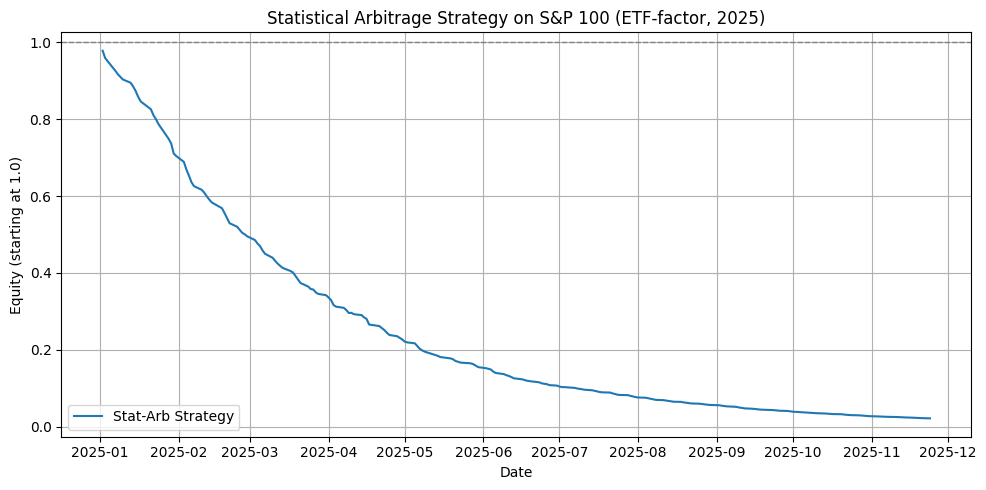

In [10]:
# -------------------------------
# 9. PLOT EQUITY CURVE
# -------------------------------

plt.figure(figsize=(10, 5))
plt.plot(equity.index, equity.values, label="Stat-Arb Strategy")
plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
plt.title("Statistical Arbitrage Strategy on S&P 100 (ETF-factor, 2025)")
plt.xlabel("Date")
plt.ylabel("Equity (starting at 1.0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
